# Steam Data Exploration: Profitable App Profiles

*This forms part of a larger series of posts for my [blog](http://nik-davis.github.io) on downloading, processing and analysing data from the steam store. [See all posts here](http://nik-davis.github.io/tag/steam).*

In [1]:
# view software version information

# http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
# %reload_ext version_information

%version_information numpy, pandas, matplotlib, seaborn, sklearn

Software versions
Python 3.7.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.5.0
OS Windows 10 10.0.18362 SP0
numpy 1.16.3
pandas 0.24.2
matplotlib 3.1.0
seaborn 0.9.0
sklearn 0.21.2
Mon Jul 08 16:22:55 2019 GMT Summer Time

In [2]:
# from IPython.display import HTML
# HTML('''
# <script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }

#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Ideas
- when will valve release half life 3
- best publishers/developers (or best and worst releases)
- older is better/ best year for games
- Is single-player dying? single vs multiplayer
- description columns - analyse sentiment/emotion

### Issues
- prediction - low correlations so difficult

In [3]:
# standard library imports
from ast import literal_eval
import itertools
import time
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_selection import RFECV

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default') # same as plt.rcdefaults(), default matplotlib style
# sns.set() # default seaborn style

## Import data and preprocess for exploration

In [4]:
def remove_non_english(df):
    df = df[df['english'] == 1].copy()
    
    # doesn't contain 3 or more non-ascii characters
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    df = df.drop('english', axis=1)
    
    return df


def calc_rating(row):

    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg

    average = pos / total_reviews

    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    cat_cols = [
#         'Local Multi-Player',
#         'MMO',
#         'Mods',
        'Multi-player',
#         'Online Co-op',
#         'Online Multi-Player',
        'Single-player'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    gen_cols = [
#         'Accounting',
        'Action',
        'Adventure',
#         'Animation & Modeling',
#         'Audio Production',
        'Casual',
#         'Design & Illustration',
#         'Documentary',
#         'Early Access',
#         'Education',
#         'Free to Play',
#         'Game Development',
#         'Gore',
        'Indie',
        'Massively Multiplayer',
#         'Nudity',
#         'Photo Editing',
        'RPG',
        'Racing',
#         'Sexual Content',
        'Simulation',
#         'Software Training',
        'Sports',
        'Strategy'
#         'Tutorial',
#         'Utilities',
#         'Video Production',
#         'Violent',
#         'Web Publishing'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
        
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # display(cat_cols, gen_cols, tag_cols)
    # df = df.drop(['categories', 'genres', 'steamspy_tags'], axis=1)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def process_year(df):
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    return df


def process_dev_pub(df):
    for col in ['developer', 'publisher']:
        col_name = col+'_rating'
        ratings = df.groupby(col).mean()['rating']
        df[col_name] = df[col].apply(lambda x: ratings[x] if x in ratings else 0)
        
        release_counts =  df.groupby(col).count()['steam_appid']
        df[col+'_releases'] = df[col].apply(lambda x: release_counts[x] if x in release_counts else 0)
        
    return df
    
def process_revenue(df):
    df['est_revenue'] = df['owners'] * df['price']
    return df


def process_price(df):
    cut_points = [-1, 0, 4, 10, 30, 50, 1000]
    label_names = ['free', 'very cheap', 'cheap', 'moderate', 'expensive', 'very expensive']
    
    df['price_categories'] = pd.cut(df['price'], cut_points, labels=label_names)
    
    return df


def pre_process():
    df = pd.read_csv('../data/steam_clean.csv')
    
    # english only
    df = remove_non_english(df)
    
    # windows only
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int) #.apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)
    # df['owners'] = df['owners'].str.replace('[+,]', '').astype(int)
    
    # calculate ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    # df = df.drop(['positive', 'negative'], axis=1)
    
    
    df = process_year(df)
    # df = process_dev_pub(df)

    # df = process_revenue(df)
    # df = process_price(df)
    
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()

print(data.isnull().sum().value_counts())
data.head()

0    30
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,124534,3339,17612,317,10000000,7.19,127873,0.973888,95.975678,2000,1,0,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,3318,633,277,62,5000000,3.99,3951,0.839787,80.508259,1999,1,0,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,3416,398,187,34,5000000,3.99,3814,0.895648,85.823915,2003,1,0,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1273,267,258,184,5000000,3.99,1540,0.826623,78.126542,2001,1,0,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,5250,288,624,415,5000000,3.99,5538,0.947996,91.260480,1999,1,1,1,0,0,0,0,0,0,0,0,0


# Data Overview

- focus on genres, owners, price, year, ratings

Take a look at KDE and scatter plots to gain some intuition about relationships between features:


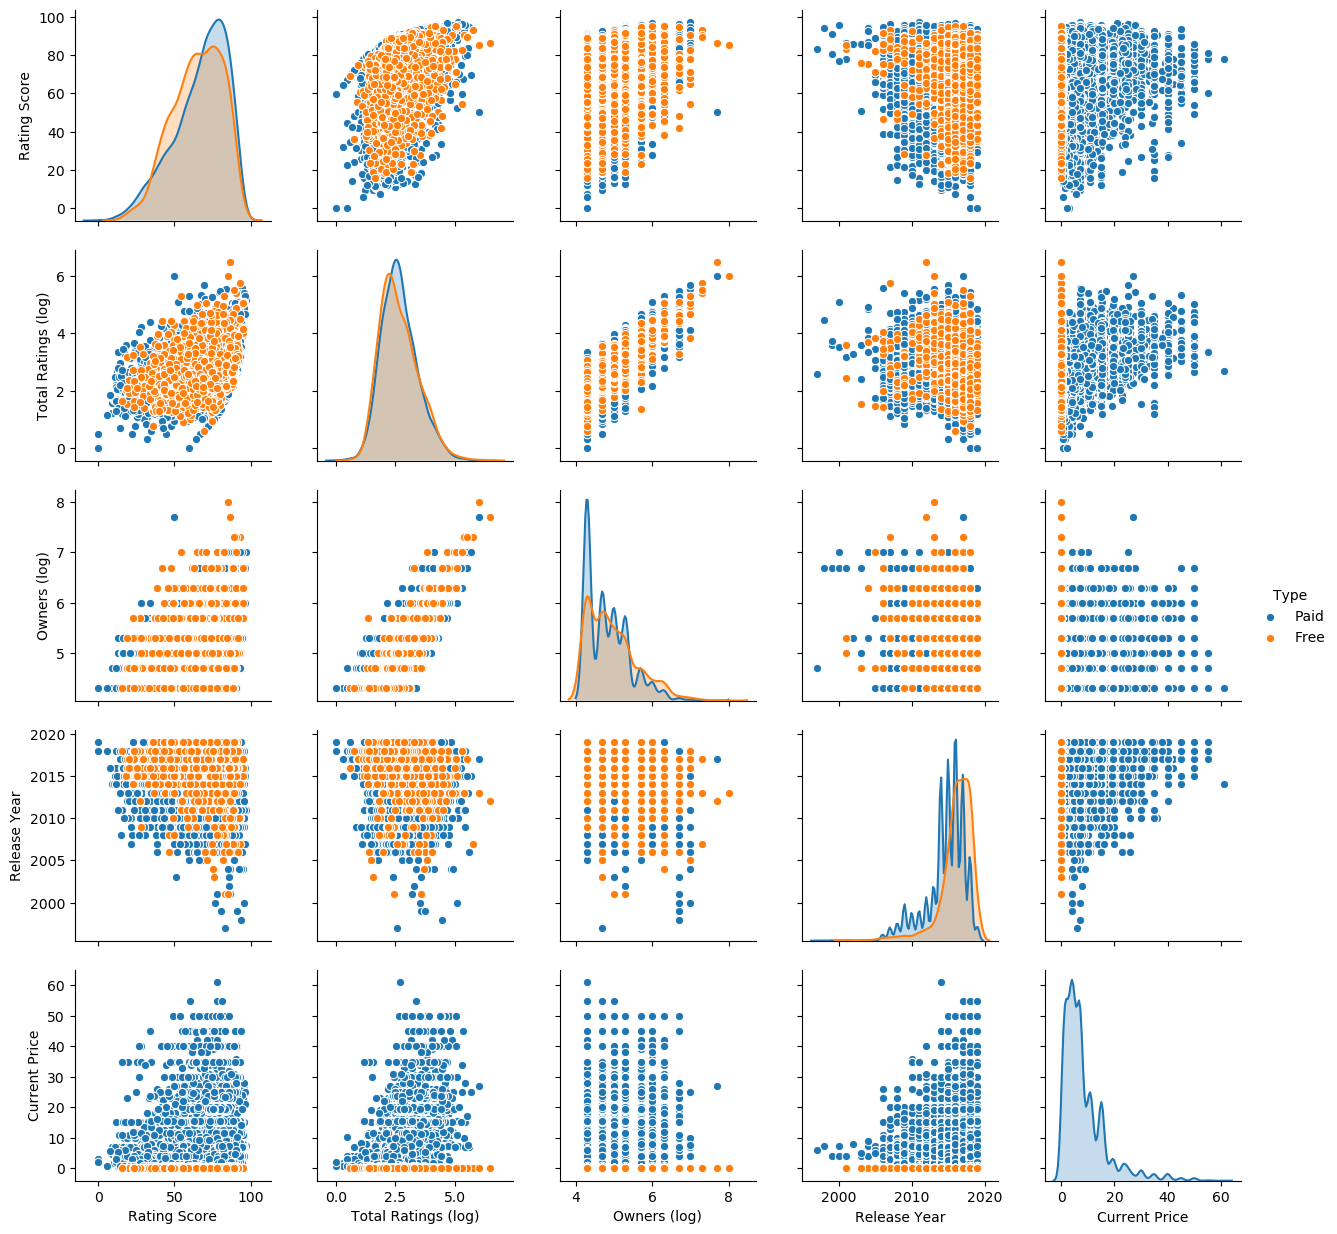

In [5]:
import warnings
warnings.filterwarnings('ignore')

data['type'] = 'Free'
data.loc[data['price'] > 0, 'type'] = 'Paid'

df = data[data['owners'] > 0].copy()

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df.price,#df[df.price>0]['price'],
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type');

warnings.filterwarnings('default')

Observations:
- Higher ratings on average for paid games
- Ratings for free games slightly more spread out

- Looks like more owners for paid games, but unclear
- Slightly more ratings given to Paid games than free

- The more owners, the more ratings
- The more owners, the higher the average rating appears to be, suggesting the better rated a game, the more people buy it

- Shift towards more Free games in recent years
- More recent games are more expensive

- Large proportion of games priced between £0 and £20, with most between £0 and £10

Trends to investigate:
- Ratings decrease over time, especially for free games
- As price increases, rating increases, suggesting people may be more likely to rate a game higher if they spent more on it? ALso, the more expensive, the more ratings it has, suggesting the more people pay the more likely they are to leave a review.

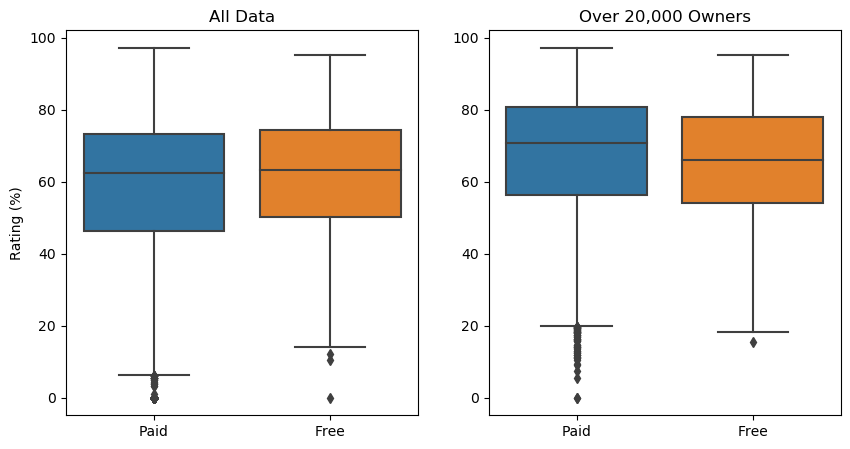

In [6]:
fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df = data.copy()
# df.boxplot(by='type', column='rating', ax=axarr[0])
sns.boxplot(x='type', y='rating', data=df, ax=axarr[0])
axarr[0].set_title('All Data')
axarr[0].set_ylabel('Rating (%)')
axarr[0].set_xlabel('')

df = data[data.owners > 0].copy()
# df.boxplot(by='type', column='rating', ax=axarr[1])
sns.boxplot(x='type', y='rating', data=df, ax=axarr[1])
axarr[1].set_title('Over 20,000 Owners')
axarr[1].set_ylabel('')
axarr[1].set_xlabel('')

plt.show()

- If look at games with over 20,000 owners, paid games receive higher ratings on average. However, if we include the games with less than 20,000 owners, paid games receive very slightly worse ratings on average. Clearly these games have a large impact on average ratings for some reason.
- For analysis, which should we choose to include? Let's take a closer look

In [7]:
print(f'Games with fewer than 20,000 owners: {data[data.owners < 20000].shape[0]}\n',
      f'Games with more than 20,000 owners: {data[data.owners >= 20000].shape[0]}')

Games with fewer than 20,000 owners: 17721
 Games with more than 20,000 owners: 8230


Taking a look at the amounts, over two thirds of games in the dataset have fewer than 20,000 owners. That's the vast majority of the dataset, and these games will have a huge impact on any analysis we make, so including them or not is a very important decision.

No right answer, but have to keep consequences in mind.

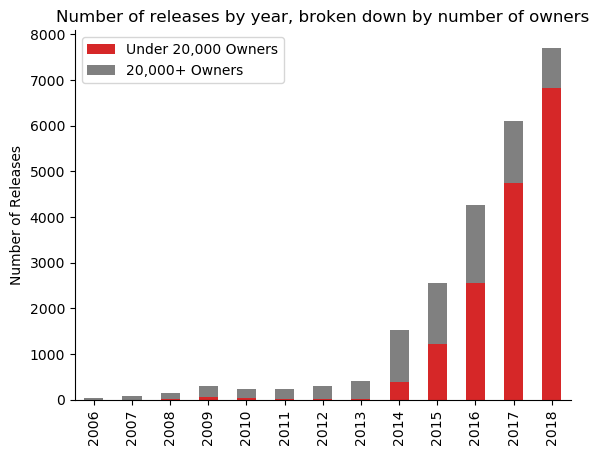

In [8]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    year_df = df[df.release_year == year]
    
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])#, figsize=(12,8))#['gray', 'red'])
ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

Looking at the chart above, 
- Since 2014, the number of releases for games having 20,000 or more owners has remained relatively constant, seen by the size of the gray bar for each year. 
- The number of releases with fewer than 20,000 owners skyrocketed in this same period. A couple of likely reasons: greenlight/direct. My interpretation is that the store has been somewhat flooded with low-quality releases, suggesting the vast majority can be ignored. 

To get useful information therefore, we will focus on games with 20,000+ owners only

Greenlight opened Aug 2012: https://store.steampowered.com/news/8761/  
Greenlight closed, Steam Direct opened Jun 2017: https://steamcommunity.com/games/593110/announcements/detail/1328973169870947116

## Release Year

We'll combine what we've just been looking at, and investigate how ratings have changed from year to year.

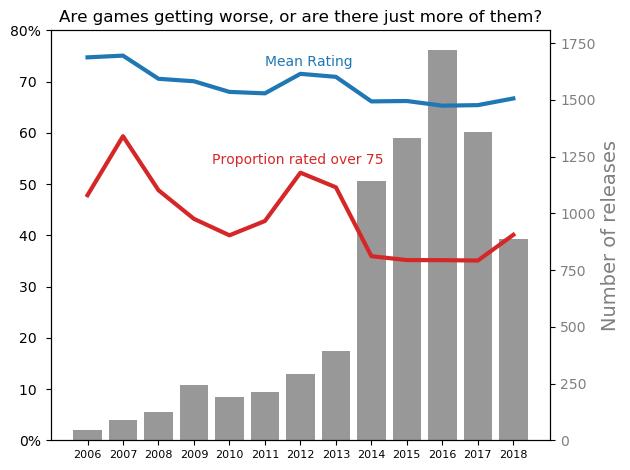

In [9]:
df = data[data.owners >= 20000].copy()

rating_threshold = 75

years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    n_high_rating = year_data[year_data['rating'] >= rating_threshold].shape[0]
    avg_rating = year_data['rating'].mean() / 100
    
    years.append(year)
    proportions.append(n_high_rating/total)
    avg_ratings.append(avg_rating)
    totals.append(total)
    
    # print(f'{year} | {n_high_rating/total:.2f}')
    
plt.rcdefaults()
fig, ax1 = plt.subplots()

ax1.set_zorder(1)
ax1.patch.set_visible(False)

x_pos = np.arange(len(years))

ax1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
ax1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=8)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

ax1.text(5, 0.73, 'Mean Rating', color='tab:blue')
ax1.text(3.5, 0.54, 'Proportion rated over 75', color='tab:red')

# ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.1))

ax2 = ax1.twinx()

color = 'tab:gray'
ax2.bar(x_pos, totals, color=color, alpha=.8)
ax2.set_ylabel('Number of releases', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title('Are games getting worse, or are there just more of them?')
fig.tight_layout()
plt.show()

Are games getting worse?

- Average rating, year on year, has fallen for the most part. 
- Peak between 2012 and 2013. Over half the games released in those years scored 75 or higher.
- As we saw, big increase from 2014, which appears to drag down the average. If we ignore the 2012/2013 peak however, there is very little change.

 # Data Overview/Genres
 - Take a look at the top rated games

,name,developer,publisher,release_year,genres,average_playtime,owners,rating,price
23,Portal 2,Valve,Valve,2011,Action;Adventure,1102,10000000,97.257760,7.19
7577,Factorio,Wube Software LTD.,Wube Software LTD.,2016,Casual;Indie;Simulation;Strategy;Early Access,10087,1000000,96.601391,21.00
2964,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,2015,RPG,3068,5000000,96.465364,24.99
17,Portal,Valve,Valve,2007,Action,288,10000000,96.103502,7.19
0,Counter-Strike,Valve,Valve,2000,Action,17612,10000000,95.975678,7.19
1120,Terraria,Re-Logic,Re-Logic,2011,Action;Adventure;Indie;RPG,5585,5000000,95.907030,6.99
1962,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",2014,Action,4583,2000000,95.871763,10.99
3036,RimWorld,Ludeon Studios,Ludeon Studios,2018,Indie;Simulation;Strategy,5017,1000000,95.802600,27.79
21,Left 4 Dead 2,Valve,Valve,2009,Action,1615,10000000,95.631142,7.19
1596,Euro Truck Simulator 2,SCS Software,SCS Software,2012,Indie;Simulation,4942,5000000,95.547966,14.99


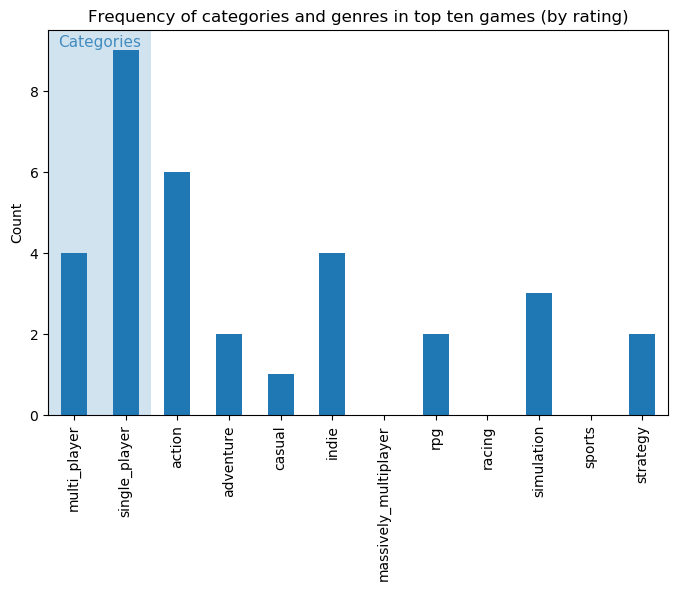

In [10]:
# df = data.drop(['required_age', 'positive_ratings', 'negative_ratings'], axis=1).copy()

display_cols = ['name', 'developer', 'publisher', 'release_year', 'genres', 'average_playtime', 'owners', 'rating', 'price']
top_ten = df.sort_values(by='rating', ascending=False).head(10)

display(top_ten[display_cols])

plt.rcdefaults()

cat_gen_cols = df.columns[-13:-1]
ax = top_ten[cat_gen_cols].sum().plot.bar(figsize=(8,5))

ax.fill_between([-.5, 1.5], 10, alpha=.2)
ax.text(0.5, 9.1, 'Categories', fontsize=11, color='tab:blue', alpha=.8, horizontalalignment='center')

ax.set_ylim([0, 9.5])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in top ten games (by rating)')

plt.show()

- Lots of these by Valve, Steam originally a platform for their games
- Good mix of older and newer games
- All have over 1 million owners

- Almost all are single player games, and over half are action
- None are massively multiplayer, racing or sports
- Can't tell much from this small sample, but we'll keep this in mind for later on

So maybe there are genres that tend to be rated more highly?

Based on what we've seen so far, we'll be focusing on paid games with 20,000 or more owners.

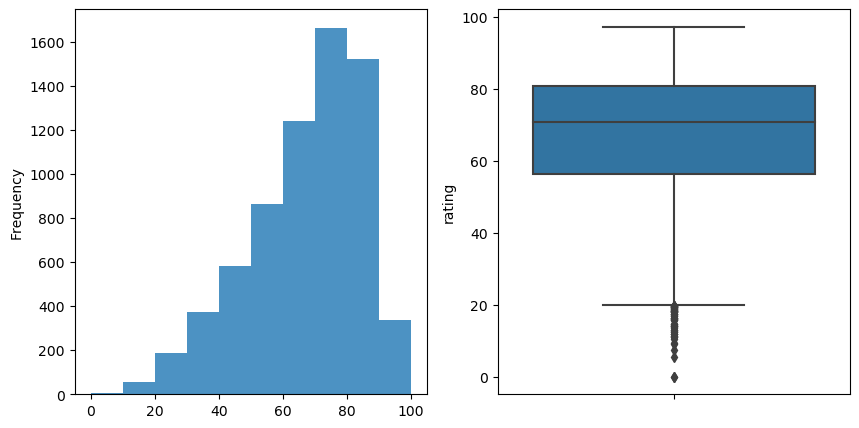

Mean rating: 67.21%


In [11]:
df = data[(data.owners >= 20000) & (data.price > 0)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.rating.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)

# sns.distplot(df.rating, bins=range(0,100,10), ax=axarr[0])
ax = sns.boxplot(x='rating', data=df, orient='v', ax=axarr[1])
plt.show()

print(f'Mean rating: {df.rating.mean():.2f}%')

- Ratings are left-skewed. Most (50%) ratings in region 60-80.


# Done to here
go on to genres vs ratings

ANOVA (analysis of variance) test.  
null hypothesis: two or more groups have the same population mean

Assumptions:
- samples are independent
- each sample is from a normally distributed population
- population standard deviations of the groups are equal (homoscedasticity)

In [12]:
import scipy.stats as stats

gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

f = stats.f_oneway(*(df.loc[df[g] == 1, 'rating'].values for g in gen_cols))

# f = stats.f_oneway(
#     df[df['action'] == 1]['rating'],
#     df[df['adventure'] == 1]['rating'],
#     df[df['casual'] == 1]['rating'],
#     df[df['indie'] == 1]['rating'],
#     df[df['massively_multiplayer'] == 1]['rating'],
#     df[df['rpg'] == 1]['rating'],
#     df[df['racing'] == 1]['rating'],
#     df[df['simulation'] == 1]['rating'],
#     df[df['sports'] == 1]['rating'],
#     df[df['strategy'] == 1]['rating']
# )

f

F_onewayResult(statistic=7.892961152519917, pvalue=1.0139122478007528e-11)

- Very small p-value means we reject the null hypothesis
- We can conclude variance in ratings is affected by genre

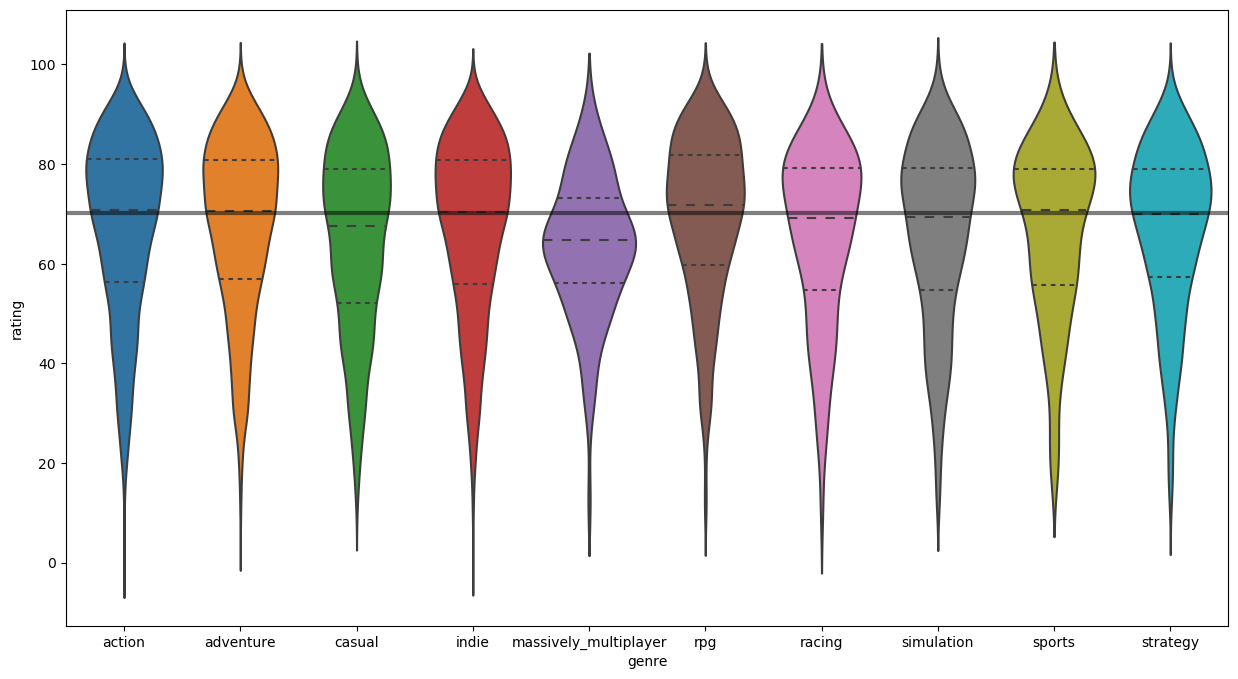

In [13]:
g_df = pd.DataFrame()

for col in gen_cols:
    ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].values, columns=['rating'])
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)

fig, ax = plt.subplots(figsize=(15,8))
sns.violinplot(x='genre', y='rating', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.rating.median(), color='black', lw=3, alpha=.5)

# ax.set_title("Don't make MMOs");
plt.show()

Because of the overlap, there are only minor differences to rating based on genre. 
- MMO much lower than others, .
- Casual lower than most, racing and simulation slightly lower
- RPG slightly better than most

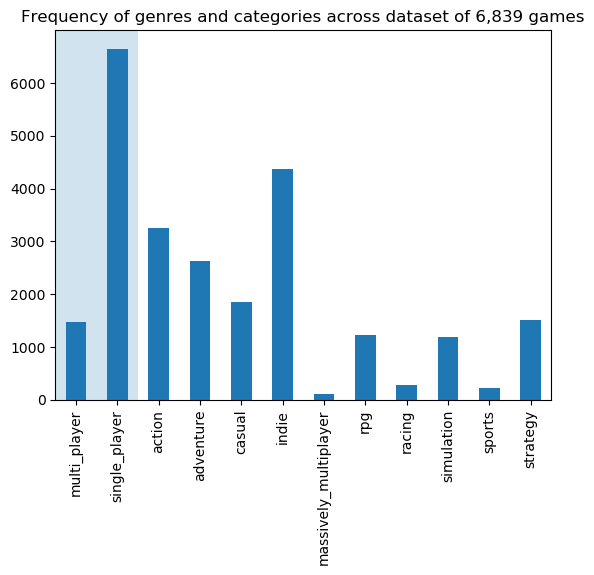

In [14]:
ax = df[cat_gen_cols].sum().plot.bar()

ax.fill_between([-.5, 1.5], 7000, alpha=.2)
ax.set_ylim([0, 6999])
ax.set_title(f'Frequency of genres and categories across dataset of {df.shape[0]:,} games')

plt.show()

- Very few MMO, racing and sports games
- Mostly indie, action, adventure in that order

- Dominated by single-player games, about a fifth are or include multi-player

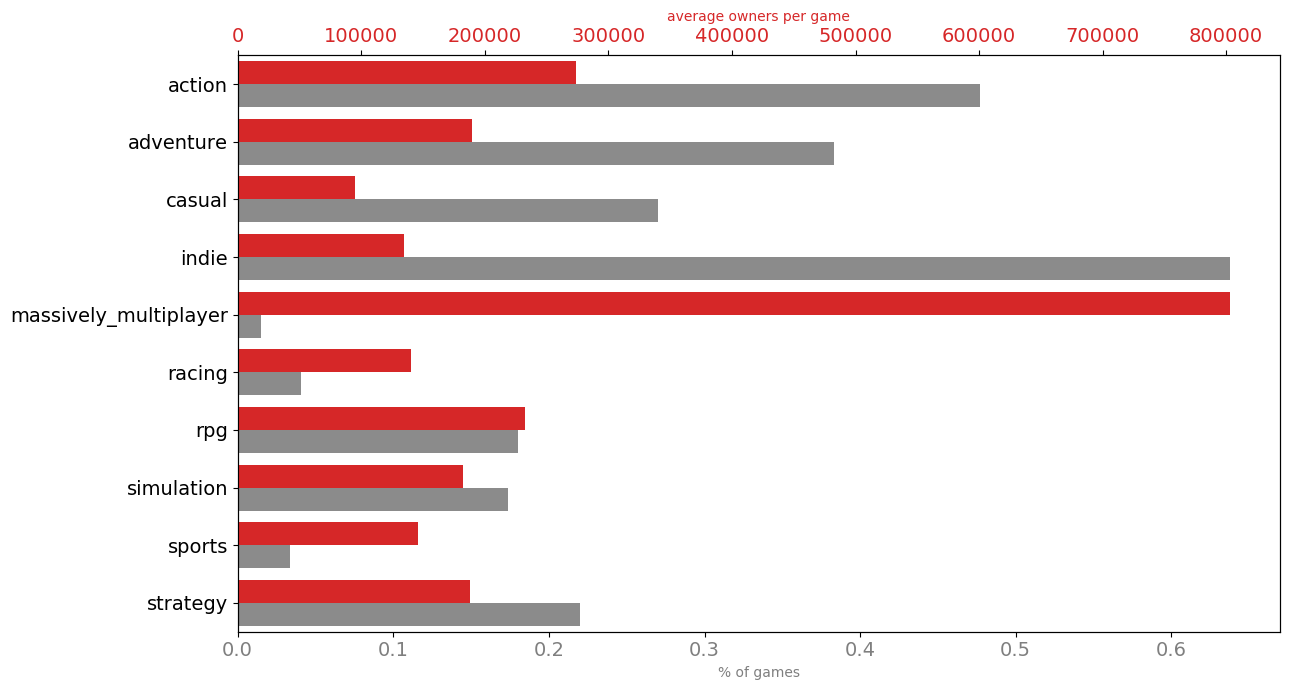

In [15]:
# percentage of apps in each genre
total_owners_per_genre = df[gen_cols].multiply(df['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

fig, ax1 = plt.subplots(figsize=(13,7))

color = 'tab:gray'
df[gen_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)
# ax1.set_ylabel('genre')

ax1.set_xlabel('% of games', color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.tick_params(axis='y', left='off', top='off')
# ax1.axes.get_yaxis().set_visible(False)

ax2 = ax1.twiny()

color = 'tab:red'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
ax2.set_xlabel('average owners per game', color=color)
ax2.tick_params(axis='x', labelcolor=color)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim([-.5, 9.5])

plt.tight_layout()
plt.show()

By comparing the average number of owners per game in each genre to the percentage of games belonging to that genre, we can draw some interesting conclusions.

First, for such a small amount of games, Massively-multipler games have a huge number of owners on average
Indie, many but low average owners

We can say that any genre with a much higher percentage than average owners is over-saturated, and the people interested in such games are inundated with options. This is the case for action, adventure, casual and indie games. There are so many games in the market that competing may be difficult, and it may be hard to stand out.

On the flipside, any genres with a low percentage of games compared to the average number of owners, suggests that there are plenty of players who would accept new games in the market, or put another way the player-base could be spread across more titles for easily.

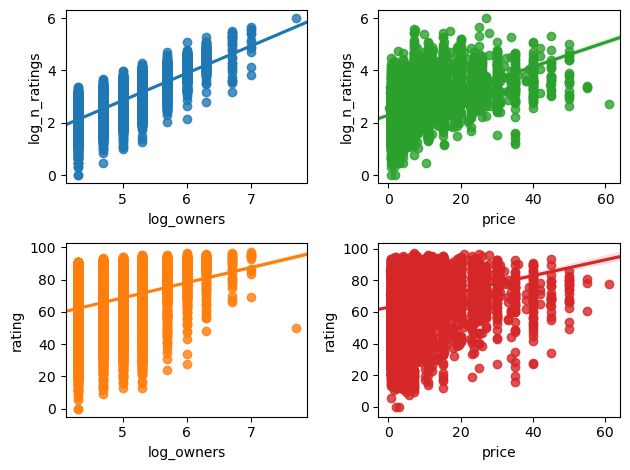

In [16]:
# log_df = pd.DataFrame([np.log10(df.owners), np.log10(df.total_ratings), df.rating], index=[['log_owners', 'log_n_ratings', 'rating']]).T

log_df = pd.DataFrame(zip(np.log10(df.owners), np.log10(df.total_ratings), df.rating, df.price),
                      columns=['log_owners', 'log_n_ratings', 'rating', 'price'])

fig, axarr = plt.subplots(2, 2)

sns.regplot(x='log_owners', y='log_n_ratings', data=log_df, ax=axarr[0][0])
sns.regplot(x='log_owners', y='rating', data=log_df, ax=axarr[1][0])
sns.regplot(x='price', y='log_n_ratings', data=log_df, ax=axarr[0][1])
sns.regplot(x='price', y='rating', data=log_df, ax=axarr[1][1])

# axarr[0][1].set_ylim([0, 6.5])

plt.tight_layout()
plt.show()

Here we can glean a couple of insights. First, looking at the left column of graphs, we see that the more owners a game has, the more ratings it has, and generally the higher those ratings are. The latter is a pretty intuitive relationship in that the better a game is, the more popular it is likely to be - low rated games are less likely to accumulate more owners. Games with high ratings can still have few owners, but we can say with confidence that very popular games will almost always have high ratings. There is one very noticable exception here, seen on the bottom-left plot, having the highest number of owners in the dataset and a rating of around fifty. We'll display that game below.

In [17]:
df[df.owners == df.owners.max()][display_cols + ['positive_ratings', 'negative_ratings']]

,name,developer,publisher,release_year,genres,average_playtime,owners,rating,price,positive_ratings,negative_ratings
12836,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,PUBG Corporation,2017,Action;Adventure;Massively Multiplayer,22938,50000000,50.066901,26.99,496184,487076


There is also a positive correlation between the price of a game and its rating, and the price and the number of reviews it receives. The implications here a two-fold: first it suggests that the more expensive a game is, the more inclined a person will be to leave for a review. Their money has value, so they want to balance the weight of that investment with feedback, be it positive, with praise, or negative, hopefully with constructive criticism about areas they didn't like, which could be improved upon in future.

The second implication is that the more someone pays for a game, the more likely they are to give it a positive rating. We don't want to delve too deeply into the implication, but it suggests that if someone pays more for a title they may be more inclined to view it positively, as otherwise would be a waste of their money. I imagine this only holds true to a point, as if they become disappointed with a game or purchase, then the more expensive it was the more likely they would be to complain, acting as a form of compensation against their investment. It could simply be that more expensive games tend to reflect a higher budget and therefore a better quality game, but it is an interesting reflection nonetheless.

Interestingly, the number of owners a game has seems to be somewhat proportional to the number of ratings it has. This means that there is a rough number of reviews you can expect in relation to a certain number of sales.

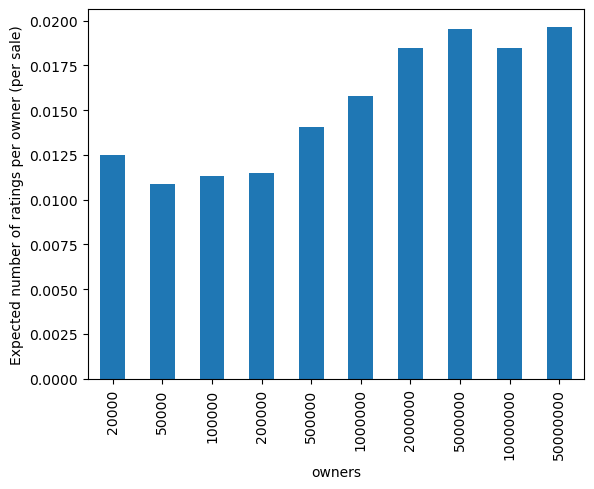

In [18]:
grp = df.groupby('owners')

ax = (grp['total_ratings'].mean() / sorted(df['owners'].unique())).plot.bar()
ax.set_ylabel('Expected number of ratings per owner (per sale)');

As the owners data is an estimation, we can't be too sure of this relationship, however with the data we have we can get a rough prediction on how many ratings we can expect based on the number of owners, or, projecting this further, based on the number of expected sales. This could help gauge the levels of support staff we'd need for a game, for example.

We could do this with other data as well, such as if our game relied on hosting servers, we could look at average playtime to inform the size of the servers we'd need. We could do with a bit more specific data here, but based on the size of the playerbase and the expected playtime, we'd have an idea of the expected load on the servers. This could be invaluable for a good launch, as there seem to be a number of cases where games have launched with insufficient servers to accomodate players, damaging the launch of a game. 

# [put some sources]()

# Pricing

- Games are likely to come down in price over time. 
- Fortunately due to Steam's frequent sales, the listed price tends to remain close to the release price.
- Still, worth looking at recent releases only

In [19]:
g_df = pd.DataFrame()

for col in gen_cols:
    temp_df = df[df[col] == 1].copy()
    temp_df['genre'] = col
    g_df = pd.concat([g_df, temp_df], axis=0)
    
# g_df = g_df[(g_df['price'] < 100)]# & (g_df['owners'] >= 100000)]
#sns.stripplot(x='price', y='genre', data=g_df, jitter=True, alpha=.5, linewidth=1)

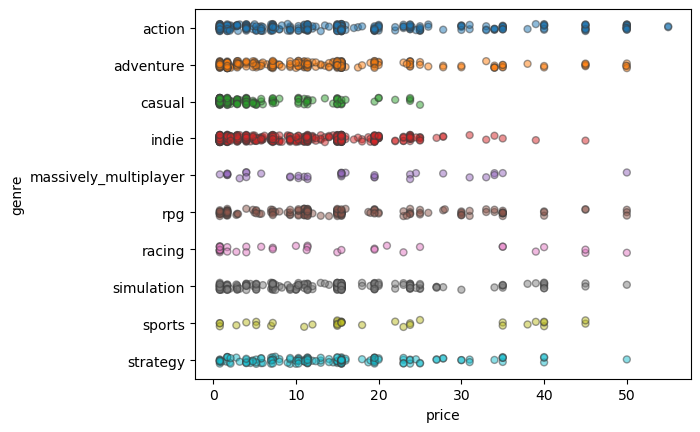

In [20]:
recent_df = g_df[g_df['release_year'] >= 2018].copy()
sns.stripplot(x='price', y='genre', data=recent_df, jitter=True, alpha=.5, linewidth=1)

Not too much can be gleaned from this except that it is very difficult to price a game over £20, and there is definitely a hard cap on pricing - around £60. This is a big enoucg topic that warrants its own discussion, but the value in terms of hours for a game is well above other forms of media. [...]

With prices not changing... hence dlc and other revenue streams for big budget titles.

## Developers and publishers

There are a few ways we could take a look at developers and publishers, to try and get an idea of the influence they have, and isolate the 'best' ones. Whilst we could rank them by a metric, such as average rating, we run into a problem:

In [121]:
pv = df.pivot_table(index='developer', 
               values=['appid', 'rating'], 
               aggfunc={'appid':'count', 'rating':np.mean})

pv = pv.rename({'appid':'num_releases'}, axis=1).sort_values(by='rating', ascending=False)

pv.head()

,num_releases,rating
developer,,
Wube Software LTD.,1,96.601391
Re-Logic,1,95.907030
Ludeon Studios,1,95.802600
ConcernedApe,1,95.490248
Gears for Breakfast,1,95.211549


The problem, as you can probably tell, is that the highest rated developers, by average game rating, have all made 1 game. It would be more useful if we could take into account a variety of parameters and turn them into a score, giving us the ability to prioritise certain values over others, like the amount of owners (as a proxy for total sales) or the total number of releases, depending on what we deem important.

In [179]:
def get_scores(df):
    num_releases = df.num_releases**(1/2)
    log_owners = np.log10(df.sum_owners)
    mean_rating = df.mean_rating
    log_ratings = np.log10(df.total_ratings)
    
    z_num_releases = stats.zscore(num_releases)
    z_log_owners = stats.zscore(log_owners)
    z_mean_rating = stats.zscore(mean_rating)
    z_log_ratings = stats.zscore(log_ratings)
    
#     for zs in [z_num_releases, z_log_owners, z_mean_rating, z_log_ratings]:
#         print(f'{zs.min():>5.2f}, {zs.max():>5.2f}, {np.median(zs):>5.2f}')
    
#     scores = sum((zs - np.median(zs))/zs.max() for zs in [z_num_releases, z_log_owners, z_mean_rating, z_log_ratings]) / 4

    # half owners and number of ratings, because allude to the same thing
    # give smaller weight to number of releases
    # rating most important, give highest weighting
    scores = (.1*z_num_releases + .5*.2*z_log_owners + .5*z_mean_rating + .5*.25*z_log_ratings) / 3
    
#     pd.Series(z_mean_rating).plot.hist()
    
#     display(
#         pd.concat([pv.reset_index(), pd.DataFrame(zip(z_num_releases, z_log_owners, z_mean_rating, z_log_ratings, scores), columns=['z_releases', 'z_owners', 'z_rating', 'z_ratings', 'scores'])], axis=1).sort_values(by='scores', ascending=False).head(20)
#     )
    
    
    return scores

pv_df = df.copy()
pv_df['num_releases'] = 1
pv = pv_df.pivot_table(index='developer',
                       values=['num_releases', 'owners', 'rating', 'total_ratings', 'price'],
                       aggfunc={'num_releases': np.sum,
                                'owners': np.sum, 
                                'rating': np.mean,
                                'total_ratings': np.sum,
                                'price': np.mean}
                      ).rename({'owners': 'sum_owners', 
                                'price': 'mean_price',
                                'rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)
pv = pv.sort_values(by='score', ascending=False)
pv.head(10)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score
developer,,,,,,
Valve,18,126000000,6.634444,87.303677,867557,0.773577
id Software,15,8200000,7.956667,82.255405,120335,0.585767
Ubisoft Montreal,17,13300000,12.931176,76.080658,442112,0.585035
Bethesda Game Studios,9,21700000,20.990000,80.215506,536724,0.555343
Daedalic Entertainment,18,3970000,17.240000,79.613358,33541,0.542076
"CAPCOM Co., Ltd.",11,9650000,24.353636,79.638252,204802,0.533004
Klei Entertainment,7,6950000,11.404286,85.510852,140137,0.522880
Square Enix,21,6150000,16.632857,71.499934,94427,0.522037
CD PROJEKT RED,4,9100000,17.590000,87.753016,282535,0.517513


By filtering through the original data, we can add the names of the top games from each developer, in case we're interested.

In [180]:
def get_top_games(pv, col='developer'):
    pv = pv.copy()
    for pv_name in pv.index:
        top_games = df[df[col] == pv_name].sort_values(by='rating', ascending=False).name

        top_5 = [n for n in top_games[:5]]

        pv.loc[pv_name, 'top_games'] = ', '.join(top_5)
        
    return pv
    
pv_top_ten_devs = get_top_games(pv.head(10))

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_devs)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score,top_games
developer,,,,,,,
Valve,18,126000000,6.634444,87.303677,867557,0.773577,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
id Software,15,8200000,7.956667,82.255405,120335,0.585767,"DOOM, QUAKE, Wolfenstein 3D, Quake III Arena, Ultimate Doom"
Ubisoft Montreal,17,13300000,12.931176,76.080658,442112,0.585035,"Tom Clancy's Splinter Cell Chaos Theory®, Assassin’s Creed® IV Black Flag™, Far Cry 3 - Blood Dragon, Assassin’s Creed® Brotherhood, Assassin's Creed 2 Deluxe Edition"
Bethesda Game Studios,9,21700000,20.990000,80.215506,536724,0.555343,"The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition, The Elder Scrolls V: Skyrim VR, Fallout 3: Game of the Year Edition"
Daedalic Entertainment,18,3970000,17.240000,79.613358,33541,0.542076,"Ken Follett's The Pillars of the Earth, Chaos on Deponia, Deponia, Edna & Harvey: Harvey's New Eyes, Memoria"
"CAPCOM Co., Ltd.",11,9650000,24.353636,79.638252,204802,0.533004,"RESIDENT EVIL 2 / BIOHAZARD RE:2, Devil May Cry 5, RESIDENT EVIL 7 biohazard / BIOHAZARD 7 resident evil, Devil May Cry® 4 Special Edition, Resident Evil / biohazard HD REMASTER"
Klei Entertainment,7,6950000,11.404286,85.510852,140137,0.522880,"Don't Starve Together, Oxygen Not Included, Invisible, Inc., Mark of the Ninja: Remastered, Shank"
Square Enix,21,6150000,16.632857,71.499934,94427,0.522037,"FINAL FANTASY VII, DRAGON QUEST® XI: Echoes of an Elusive Age™ - Digital Edition of Light, FINAL FANTASY IX, FINAL FANTASY X/X-2 HD Remaster, FINAL FANTASY VIII"
CD PROJEKT RED,4,9100000,17.590000,87.753016,282535,0.517513,"The Witcher® 3: Wild Hunt, The Witcher 2: Assassins of Kings Enhanced Edition, The Witcher: Enhanced Edition Director's Cut, Thronebreaker: The Witcher Tales"


Repeat for publishers

In [173]:
pv = pv_df.pivot_table(index='publisher',
                       values=['num_releases', 'owners', 'rating', 'total_ratings', 'price'],
                       aggfunc={'num_releases': np.sum,
                                'owners': np.sum, 
                                'rating': np.mean,
                                'total_ratings': np.sum,
                                'price': np.mean}
                      ).rename({'owners': 'sum_owners', 
                                'price': 'mean_price',
                                'rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)

pv_top_ten_pubs = get_top_games(pv.sort_values(by='score', ascending=False).head(10), col='publisher')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_pubs)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score,top_games
publisher,,,,,,,
Ubisoft,94,38710000,17.579362,73.002302,1050848,0.703788,"South Park™: The Stick of Truth™, Valiant Hearts: The Great War™ / Soldats Inconnus : Mémoires de la Grande Guerre™, Child of Light, Dark Messiah of Might & Magic, Trackmania United Forever Star Edition"
Valve,21,146000000,6.399524,87.802773,1257491,0.668626,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
Devolver Digital,56,17150000,10.313214,79.531172,309556,0.630958,"Hotline Miami, Broforce, Downwell, Katana ZERO, GRIS"
Square Enix,82,28000000,12.370488,71.355954,350595,0.629798,"Supreme Commander: Forged Alliance, Deus Ex: Game of the Year Edition, FINAL FANTASY VII, Just Cause 2, DRAGON QUEST® XI: Echoes of an Elusive Age™ - Digital Edition of Light"
SEGA,62,28670000,14.731935,76.713634,263964,0.627571,"Warhammer® 40,000: Dawn of War® - Dark Crusade, Warhammer® 40,000: Dawn of War® - Soulstorm, Warhammer® 40,000: Dawn of War® - Game of the Year Edition, Rome: Total War™ - Collection, Valkyria Chronicles™"
Bethesda Softworks,30,38450000,16.990000,79.860181,911349,0.590933,"Dishonored, Fallout: New Vegas, The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition"
THQ Nordic,82,15470000,12.304634,66.744983,122256,0.548319,"Neighbours from Hell Compilation, Impossible Creatures Steam Edition, Titan Quest Anniversary Edition, The Book of Unwritten Tales, The Book of Unwritten Tales 2"
Paradox Interactive,54,25910000,14.188148,69.173878,403285,0.537603,"Prison Architect, Cities: Skylines, Magicka, Crusader Kings II, Knights of Honor"
Electronic Arts,32,25520000,12.427500,77.736716,210195,0.536891,"Mass Effect 2, Dead Space™ 2, Mass Effect, Dragon Age: Origins, Dragon Age: Origins - Ultimate Edition"


Now we have an idea of the top developers and publishers, let's investigate the games they tend to make. One way we could do this is by looking at the proportion of games they make in each genre. For each game from a publisher, every genre column has a 1 or a 0, so by looking at the sum or mean of these columns, we can figure out how many and what proportion of games are in each genre.

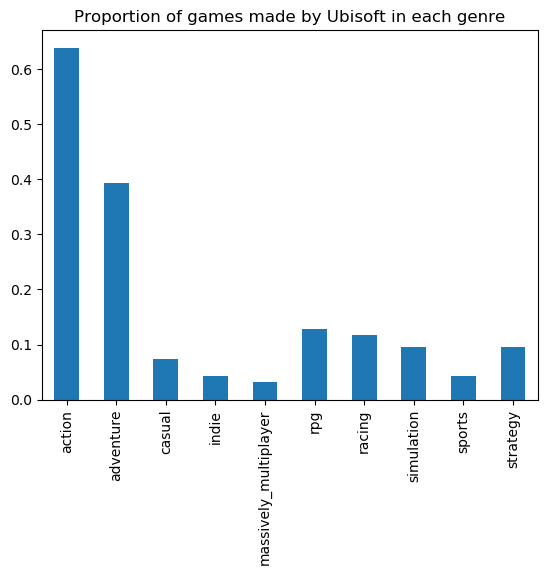

In [169]:
df[df.publisher == 'Ubisoft'][gen_cols].mean().plot.bar()
plt.title('Proportion of games made by Ubisoft in each genre');
# fig, axarr = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,5))

# for i, p in enumerate(top_ten.index):
#     df[df.publisher == p][gen_cols].mean().plot.bar(ax=axarr[i//5][i%5])
#     axarr[i//5][i%5].set_title(p)

Just by looking at Ubisoft's games, we can see that a little over 60% of them are action, and just under 40% are adventure, with a scattering of games across the other genres. If we were to categorise the games they made I think it would be reasonable to say they make predominantly action or action-adventure games. 

If we wanted to make this process a little easier, instead of manually generating and reading a chart, we could look at the maximum value after computing the mean, giving us the 'most common' genre from that publisher. This way we could feed in the name of any known publisher (or developer), and return the genre of game they most commonly make.

In [174]:
for publisher in pv_top_ten_pubs.index:
    most_common_genre = df[df.publisher == publisher][gen_cols].mean().idxmax()
    print(f'Generally, {publisher} make {most_common_genre} games.')

Generally, Ubisoft make action games.
Generally, Valve make action games.
Generally, Devolver Digital make indie games.
Generally, Square Enix make action games.
Generally, SEGA make action games.
Generally, Bethesda Softworks make action games.
Generally, THQ Nordic make action games.
Generally, Paradox Interactive make strategy games.
Generally, Electronic Arts make action games.
Generally, Sekai Project make indie games.


This is a good start, but as we just saw, Ubisoft can be better described by looking at their top two genres, action and adventure. 

We could simply return the top two genres, but that may not be appropriate for all of the publishers. Some may mainly make one type of game, like Valve

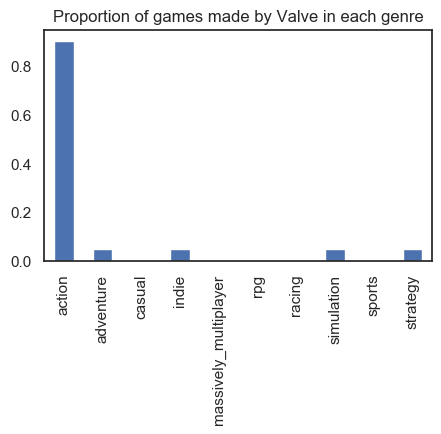

In [187]:
df[df.publisher == 'Valve'][gen_cols].mean().plot.bar(figsize=(5,3))
plt.title('Proportion of games made by Valve in each genre');

And others, like THQ Nordic, may be split across a large number of genres.

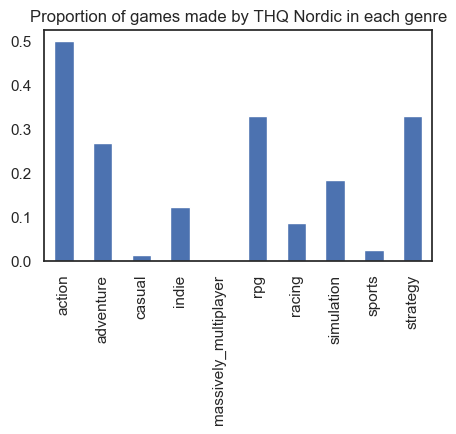

In [188]:
df[df.publisher == 'THQ Nordic'][gen_cols].mean().plot.bar(figsize=(5,3))
plt.title('Proportion of games made by THQ Nordic in each genre');

Let's try and define a little more complex logic. We can calculate the proportions of the proportions, then use a while loop to total them up until a threshold is reached, say 0.5 for half. 

This way, if one genre dominates, we can return just that genre, whereas if there is a more varied mix, we can combine these to more accurately reflect the nature of the games made by a particular publisher.

In [194]:
for publisher in pv_top_ten_pubs.index:
    gen_values = df[df.publisher == publisher][gen_cols].mean().sort_values(ascending=False)
    
    total = gen_values.sum()
    proportions = [val / total for val in gen_values]
    
    gen_proportions = pd.DataFrame(zip(gen_values, proportions), index=gen_values.index, columns=['mean', 'proportion'])
    
    total_proportion = 0
    i = 0
    genres = []
    
    while total_proportion < .5:
        row_prop = gen_proportions.iloc[i, 1]
        genres.append(gen_proportions.index[i])
        total_proportion += row_prop
        i += 1
    
    print(f'{publisher} make {"/".join(genres)} games.')

Ubisoft make action/adventure games.
Valve make action games.
Devolver Digital make indie/action games.
Square Enix make action/rpg games.
SEGA make action/strategy/adventure games.
Bethesda Softworks make action/rpg games.
THQ Nordic make action/strategy/rpg games.
Paradox Interactive make strategy/rpg games.
Electronic Arts make action/rpg games.
Sekai Project make indie/casual games.


In a way this is like a very simple machine learning model in that it takes some inputs and 'predicts' the types a games a publisher makes based on what it has made so far. Going forward, we may wish to experiment with applying some machine learning models to our dataset, so next, and finally, we'll take a look at some correlations.

## Correlations

As a final bit of exploration let's take a look at correlations

Already somewhat investigated but take a look here because would inform machine learning options. 

C:\Users\nikda\Miniconda3\envs\py37\lib\site-packages\seaborn\palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
C:\Users\nikda\Miniconda3\envs\py37\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


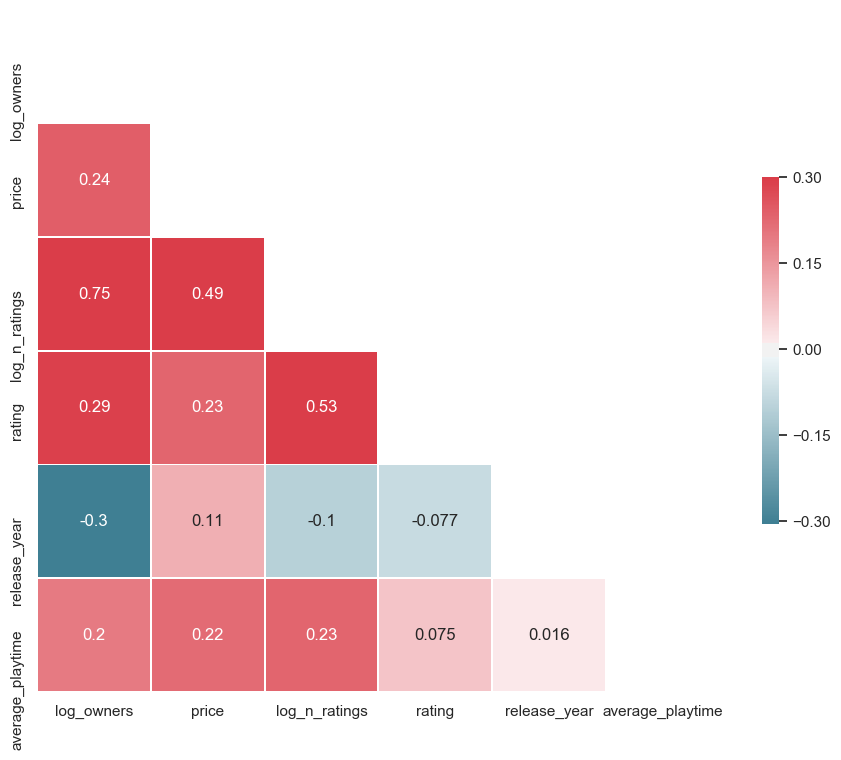

In [177]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.show()

corr_df = df.copy()
corr_df['log_owners'] = np.log10(temp_df['owners'])
corr_df['log_n_ratings'] = np.log10(temp_df['total_ratings'])
# temp_df = temp_df[df['owners'] >= 100000]

plot_correlation_heatmap(corr_df[['log_owners', 'price', 'log_n_ratings', 'rating', 'release_year', 'average_playtime']])

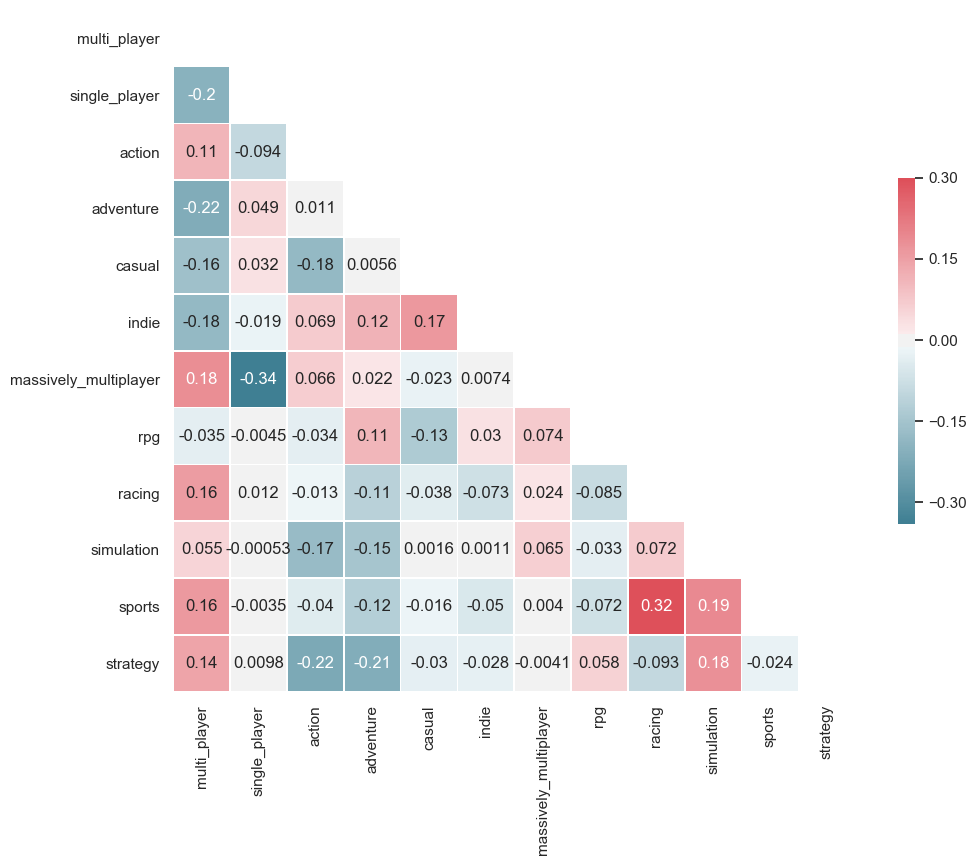

In [178]:
plot_correlation_heatmap(corr_df[cat_gen_cols])

Interesting to look at which genres correlate with others, suggesting the genre types which do or do not mix. For example racing games tend to be sports games, which makes sense, and single-player games aren't usually massively-multiplayer games - the clue's in the name there! 